# Virtual data set (VDS) reference file for SCATSAT1_ESDR_L2_WIND_STRESS_V1.1 using Virtualizarr

Saves VDS as parquet file. SCATSAT1_ESDR_L2_WIND_STRESS_V1.1 is an L2 data set with no time dimension, so this is an example of saving along a newly created dimension.

In [1]:
# Built-in packages
import os
import sys
import shutil

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import pandas as pd

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
from distributed.utils import silence_logging_cmgr
import coiled

# Other
import matplotlib.pyplot as plt

## 1. Get Data File S3 endpoints in Earthdata Cloud

In [62]:
# Get Earthdata creds
earthaccess.login()

In [63]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [5]:
# Locate CCMP file information / metadata:
granule_info = earthaccess.search_data(
    short_name="SCATSAT1_ESDR_L2_WIND_STRESS_V1.1",
    count=100
    )

In [6]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print(len(data_s3links))
data_s3links[0:3]

100


['s3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08002_v1.1_s20180401-011908-e20180401-025826.nc',
 's3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08003_v1.1_s20180401-025826-e20180401-043745.nc',
 's3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08004_v1.1_s20180401-043745-e20180401-061703.nc']

## 2. Generate single-orbit reference files

One file per orbit, so one reference file per orbit.

In [7]:
n_files_process = 13145

In [8]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set:
coord_vars = ["lat","lon"]

In [9]:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 4


In [10]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.

In [11]:
# Start up cluster and print some information about it:
client = Client(n_workers=4, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

LocalCluster(e0f188b3, 'tcp://127.0.0.1:46215', workers=4, threads=4, memory=14.47 GiB)
View any work being done on the cluster here https://cluster-pqbbb.dask.host/jupyter/proxy/8787/status


2025-10-22 23:41:46,476 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-wind_stress_magnitude-f9cb978a807d0de49fb4eaa2aca0a221' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7c55c85c28e0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7c554bcdb900>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x7c55ca2ab2

In [12]:
%%time
# Create individual references:
open_vds_par = delayed(open_virtual_dataset)
tasks = [
    open_vds_par(p, indexes={}, reader_options=reader_opts, loadable_variables=coord_vars) 
    for p in data_s3links[:n_files_process]
    ]
virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.

CPU times: user 5.37 s, sys: 3.62 s, total: 8.99 s
Wall time: 38.2 s


## 3. Generate combined reference files

Several combined reference files will be tried:
1. **Combine along a newly created time dimension:** The dimension will be "orbit start time", so get the start time from each file using the granule metadata. Convert those times into cf-compliant formats (e.g. "second since ...").
2. **Combine along a newly created granule ID dimension:** The dimension will be "granule ID", so get the granule ID from each file using the granule metadata.
3. **Combine along the along-track dimension:** This would be equivalent to having a single large file that continuously accumulated data as the satellite continued to orbit.

## 3.1 Combine along a newly created time dimension

In [13]:
## The dimension will be "orbit start time", so get the start time from each file using the granule metadata:

basetime_str = "1970-01-01T00:00:00Z" # times will be measured in seconds since this basetime. 

orbit_starttime_list = []
for g in granule_info[:n_files_process]:
    datetime_str = g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']
    datetime_obj = np.datetime64(datetime_str)
    basetime_obj = np.datetime64(basetime_str)
    timedelt = np.timedelta64(datetime_obj - basetime_obj, 's').astype(int)
    orbit_starttime_list.append(timedelt)

/tmp/ipykernel_12848/904977041.py:8: UserWarning: no explicit representation of timezones available for np.datetime64
  datetime_obj = np.datetime64(datetime_str)
/tmp/ipykernel_12848/904977041.py:9: UserWarning: no explicit representation of timezones available for np.datetime64
  basetime_obj = np.datetime64(basetime_str)


In [14]:
## Wrap the orbit start time data in an xarray.DataArray, assigning CF-aligned attributes:
orbit_starttime_da = xr.DataArray(
    data=orbit_starttime_list,
    name="orbit_start_time",
    dims=["orbit_start_time"],
    attrs=dict(
        units="seconds since " + basetime_str,
        calendar = "gregorian"
    )
)

In [15]:
%%time
# Create the combined reference
virtual_ds_combined = xr.concat(virtual_ds_list, orbit_starttime_da, coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 459 ms, sys: 5.44 ms, total: 464 ms
Wall time: 459 ms


In [16]:
virtual_ds_combined

<xarray.Dataset> Size: 6GB
Dimensions:                        (orbit_start_time: 100, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB ...
    lon                            (along_track, cross_track) float32 2MB ...
  * orbit_start_time               (orbit_start_time) int64 800B 1522545549 ....
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    real_wind_u_error              (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    flags                          (orbit_start_time, along_track, cross_track) int32 197MB ManifestArray<shape=(100, 3248, 152), dtype=int32, chunks=...
    quality_indicator              (orbit_start_time, along_track, cross_track) int16 99MB ManifestArray<shape=(100, 3248, 152), dtype=int16, chunks=(...
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    ...                             ...
    time                           (orbit_start_time, along_track) float64 3MB ManifestArray<shape=(100, 3248), dtype=float64, chunks=(1, 3248...
    en_wind_u_error                (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    en_wind_u                      (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    rain_speed_bias                (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    nudge_wind_speed               (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [17]:
# Save in JSON and PARQUET formats:
fname_combined_json = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-time.json'
fname_combined_parq = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-time.parq'
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_parq, format='parquet')

## 3.2 Combine along a newly created granule ID dimension

In [18]:
## Get the granule ID from each file using the granule metadata:
gran_id = [g['meta']['concept-id'] for g in granule_info]

In [19]:
## Wrap the orbit start time data in an xarray.DataArray, assigning CF-aligned attributes:
gran_id_da = xr.DataArray(
    data=gran_id,
    name="granule_id",
    dims=["granule_id"]
)

In [20]:
%%time
# Create the combined reference
virtual_ds_combined = xr.concat(virtual_ds_list, gran_id_da, coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 458 ms, sys: 1 ms, total: 459 ms
Wall time: 452 ms


In [21]:
virtual_ds_combined

<xarray.Dataset> Size: 6GB
Dimensions:                        (granule_id: 100, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB ...
    lon                            (along_track, cross_track) float32 2MB ...
  * granule_id                     (granule_id) <U19 8kB 'G2915919268-POCLOUD...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    real_wind_u_error              (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    flags                          (granule_id, along_track, cross_track) int32 197MB ManifestArray<shape=(100, 3248, 152), dtype=int32, chunks=(1, 32...
    quality_indicator              (granule_id, along_track, cross_track) int16 99MB ManifestArray<shape=(100, 3248, 152), dtype=int16, chunks=(1, 324...
    en_wind_speed                  (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    wind_stress_u                  (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    en_wind_direction_error        (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    ...                             ...
    time                           (granule_id, along_track) float64 3MB Mani...
    en_wind_u_error                (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    en_wind_direction              (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    en_wind_u                      (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    rain_speed_bias                (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    nudge_wind_speed               (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [22]:
# Save in JSON and PARQUET formats:
fname_combined_json = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-granid.json'
fname_combined_parq = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-granid.parq'
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_parq, format='parquet')

## 3.3 Generate combined reference file along `along_track` dimension

So far, running the code to create the combined reference file hangs up indefinitely.

In [48]:
%%time
# Create the combined reference
virtual_ds_combined = xr.combine_nested(virtual_ds_list, concat_dim='along_track', coords='minimal', compat='override', combine_attrs='drop_conflicts')
#virtual_ds_combined = xr.concat(virtual_ds_list, 'along_track', coords='minimal', compat='override', combine_attrs='drop_conflicts')

Exception ignored in: <function File.close at 0x7f1d283bde40>
Traceback (most recent call last):
  File "/opt/coiled/env/lib/python3.12/site-packages/h5netcdf/core.py", line 1676, in close
    if not self._closed:
           ^^^^^^^^^^^^
AttributeError: 'File' object has no attribute '_closed'

KeyboardInterrupt



## 4. Test reference files

The primary objective is to be able to do both temporal and spatial search with the same VDS. The hope is that temporal and spatial search with the `earthaccess` package can be translated to subsetting along one or more of the VDS dims.

## 4.1 First confirm that spatial search is working as expected in earthaccess

Temporal search is assumed to work, spatial search is the trickier one. Want to verify that earthaccess is accurately finding all granules in a given bounding box.

In [51]:
bbox_pm180 = (-20, -20, 0, 0)  # bounding box over longitude range -180, 180.
bbox_0360 = (340, -20, 360, 0)  # bounding box over longitude range 0, 360.
bbox_width = bbox_0360[2] - bbox_0360[0]
bbox_height = bbox_0360[3] - bbox_0360[1]

In [52]:
# Locate granule metadata in bbox of interest:
granule_info_bbox = earthaccess.search_data(
    short_name="SCATSAT1_ESDR_L2_WIND_STRESS_V1.1",
    bounding_box = bbox_pm180,
    count=10
    )

In [53]:
fileobjs_bbox = earthaccess.open(granule_info_bbox)

QUEUEING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10 [00:00<?, ?it/s]

In [58]:
datetimes_str = [g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'] for g in granule_info_bbox]
datetimes_obj = [np.datetime64(dts) for dts in datetimes_str]

/tmp/ipykernel_12848/998139349.py:2: UserWarning: no explicit representation of timezones available for np.datetime64
  datetimes_obj = [np.datetime64(dts) for dts in datetimes_str]


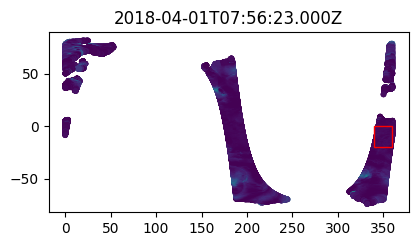

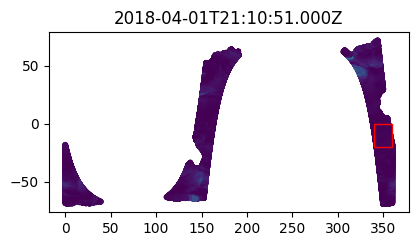

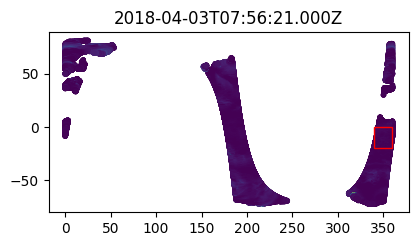

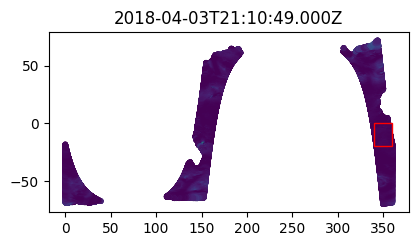

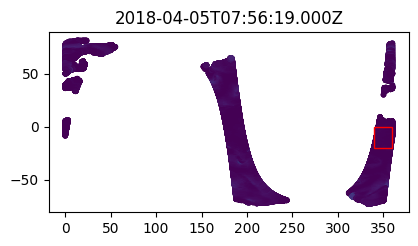

In [59]:
n_plot = 5
figs = [plt.figure(figsize=(4,2)) for n in range(n_plot)]
axes = [f.add_axes((0, 0, 0.9, 0.9)) for f in figs]

for fo, ax, dts in zip(fileobjs_bbox[:n_plot], axes, datetimes_str[:n_plot]):
    data = xr.open_dataset(fo)
    bbox_patch = plt.Rectangle(
        (bbox_0360[0], bbox_0360[1]), bbox_width, bbox_height, 
        edgecolor='red', facecolor='none'
    )
    ax.add_patch(bbox_patch)
    ax.set_title(dts)
    ax.scatter(data['lon'], data['lat'], c=data['wind_stress_magnitude'], marker='.', zorder=-99)

## 4.2 Test spatial search with VDS's

In [60]:
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

## 4.2.1 VDS with added time dimension 

In [65]:
%%time
data_vds = opends_withref('ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-time.json', fs)
data_vds

CPU times: user 38.6 ms, sys: 7.42 ms, total: 46 ms
Wall time: 256 ms


<xarray.Dataset> Size: 7GB
Dimensions:                        (orbit_start_time: 100, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
    lon                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 800B 201...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [71]:
data_vds_bbox = data_vds.sel(orbit_start_time = datetimes_obj)
data_vds_bbox

<xarray.Dataset> Size: 676MB
Dimensions:                        (orbit_start_time: 10, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
    lon                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 80B 2018...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

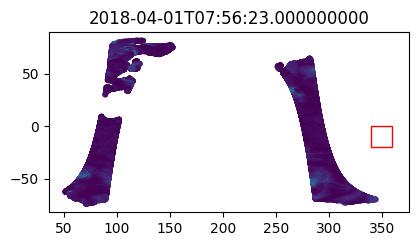

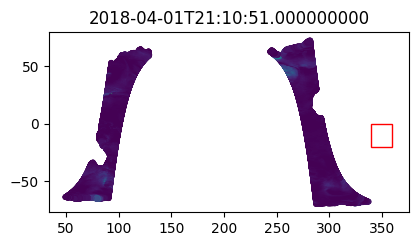

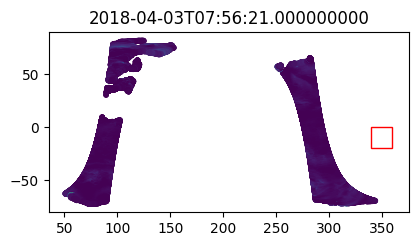

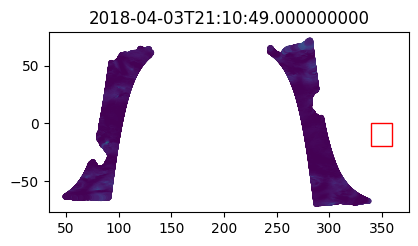

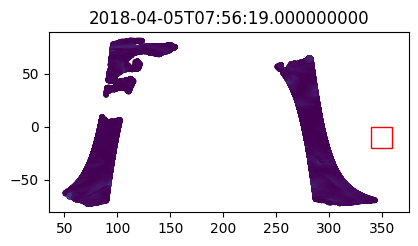

In [72]:
n_plot = 5
figs = [plt.figure(figsize=(4,2)) for n in range(n_plot)]
axes = [f.add_axes((0, 0, 0.9, 0.9)) for f in figs]

for ax, dt in zip(axes, data_vds_bbox["orbit_start_time"].values[:n_plot]):
    data_sub = data_vds_bbox.sel(orbit_start_time = dt)
    bbox_patch = plt.Rectangle(
        (bbox_0360[0], bbox_0360[1]), bbox_width, bbox_height, 
        edgecolor='red', facecolor='none'
    )
    ax.add_patch(bbox_patch)
    ax.set_title(dt)
    ax.scatter(data_sub['lon'], data_sub['lat'], c=data_sub['wind_stress_magnitude'], marker='.', zorder=-99)

In [39]:
%%time
data = opends_withref('ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-time.json', fs)
data

CPU times: user 45 ms, sys: 6.55 ms, total: 51.6 ms
Wall time: 234 ms


<xarray.Dataset> Size: 7GB
Dimensions:                        (gran_num: 100, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
    lon                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
Dimensions without coordinates: gran_num, along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (gran_num, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [6]:
starttime = np.datetime64("2018-05-01T00:00:00") 
endtime = np.datetime64("2018-05-02T12:00:00")
data.sel(orbit_start_time=slice(starttime, endtime))

<xarray.Dataset> Size: 1GB
Dimensions:                        (orbit_start_time: 21, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
    lon                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 168B 201...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [10]:
%%time
#data.sel(orbit_start_time=slice(starttime, endtime))["real_wind_speed"].mean().compute()
ts = data.sel(orbit_start_time=slice(starttime, endtime))["real_wind_speed"].mean(dim=["along_track","cross_track"]).compute()

CPU times: user 258 ms, sys: 27.5 ms, total: 285 ms
Wall time: 578 ms


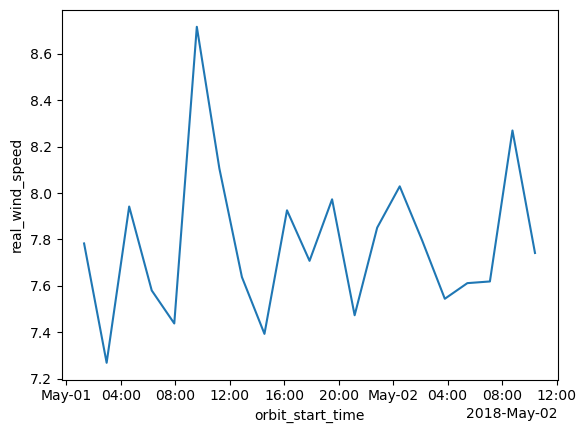

In [11]:
ts.plot()

## 4. Generate combined reference file along a new "granule ID" dimension

The dimension will be "granule ID", so get the granule ID from each file using the granule metadata.

## 4.2. Test reference file

Open data set using the reference file. Try out some temporal subsetting and taking the global mean of that subset

In [83]:
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

In [84]:
%%time
data = opends_withref('ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-granid.json', fs)
data

CPU times: user 45 ms, sys: 1.41 ms, total: 46.4 ms
Wall time: 273 ms


<xarray.Dataset> Size: 7GB
Dimensions:                        (granule_id: 100, along_track: 3248,
                                    cross_track: 152)
Coordinates:
  * granule_id                     (granule_id) object 800B 'G2915919268-POCL...
    lat                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
    lon                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (granule_id, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [95]:
bbox = (160, -20, 0, 0)

In [ ]:
# Locate granule metadata in bbox of interest:
granule_info_bbox = earthaccess.search_data(
    short_name="SCATSAT1_ESDR_L2_WIND_STRESS_V1.1",
    bounding_box = bbox,
    #count=10
    )

gran_id_bbox = [g['meta']['concept-id'] for g in granule_info_bbox][:10]

In [ ]:
ts = data.sel(granule_id=gran_id_bbox)
ts

In [ ]:
#bbox_patch = matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], 
                                          
for gid in ts['granule_id'][:2]:
    data_gid = ts.sel(granule_id=gid)
    fig = plt.figure()
    ax = plt.axes()
    bbox_patch = plt.Rectangle((160, -20), 20, 20, edgecolor='red', facecolor='none')
    ax.add_patch(bbox_patch)
    plt.scatter(data_gid['lon'], data_gid['lat'], c=data_gid['wind_stress_magnitude'], marker='.')

In [10]:
%%time
#data.sel(orbit_start_time=slice(starttime, endtime))["real_wind_speed"].mean().compute()
ts = data.sel(granule_id=gran_id_bbox)["real_wind_speed"].mean(dim=["along_track","cross_track"]).compute()

CPU times: user 258 ms, sys: 27.5 ms, total: 285 ms
Wall time: 578 ms


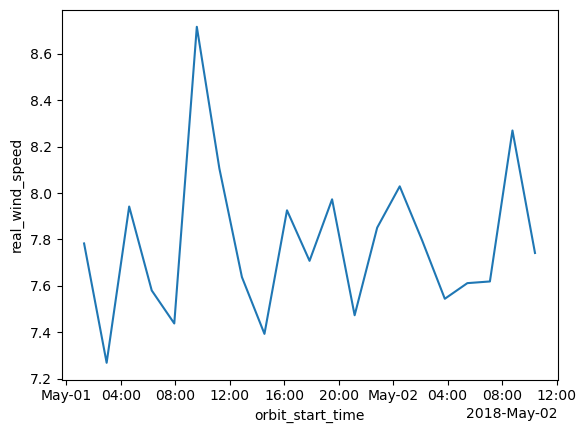

In [11]:
ts.plot()